# University of Edinburgh - Undergraduate Research Assistantship under Dr. Tiancheng Sun

## _"The Turtle Strategy: Simplified"_  by Nicholas Roy

#### _Summary_: 
- An increase in GBM percentage drift parameter, mu, increases average returns and normalizes the return distribution. An increase in GBM percentage volatility parameter, sigma, increases the variance of returns and decreases average returns.
- A low mu and low sigma may be preferered to a high mu and high sigma, indicating that the latter is not able to sufficiently compensate the increased risk of high sigma with the higher reward of increased mu (all else equal, sigma comes with a return penalty in addition to its risk increase). 
- Paths with flat, rangebound prices lead to lower returns than paths with strong negative trends, because the strategy continues to enter false signals.

## I. Turtle Strategy: Baseline Rules

1. __Entry/Exit:__
    - Entry into long positions are triggered when the price exceeds the upper 20-period Donchina channel (the moving maximimum value of the past 20 periods).
    - Exit from an active long position is triggered when the price drops below the lower 20-period Donchian channel (the moving minimum of the past 10 periods).
    - Because the exit breakout period is shorter than the entry period, exits are more reactive than entries; that is, larger price movements are often required to trigger entry than exit, because the 20 period Donchian channels have a longer memory of prior maxima. 

## II. Simulating the Turtle Strategy  with Geometric Brownian Motion (GBM)

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
import yfinance as yf
from scipy.interpolate import griddata
import statsmodels.formula.api as smf

np.random.seed(42)

In [2]:
# Define Simplified Turtle Strategy Simulation Object

class sim_turtle1():
    def __init__(self):
        # Path attributes
        self.path_params = None
        self.path = None
        self.open = None
        self.close = None
        self.high = None
        self.low = None
        
        # Account attributes
        self.equity_curve = None
        self.profit = None
        self.num_trans = 0
        self.final_return = None
        self.return_maxdraw = None
        self.winning_segments = []
        self.winning_segment_returns = []
        self.losing_segments = []
        self.losing_segment_returns = []
        

    def sim_stochastic(self, path_params):
        ''' Generate synthetic prices using Geometric Brownian Motion (GBM) '''
        mu, sigma, S0, n, prices_per_n = path_params
        
        T = n / 252                  # Trading period in terms of years
        dt = T / (prices_per_n*n)    # Multiply number of price points to generate Open, High, Low, and Close
        t = np.linspace(0, T, n)
        self.path_params = mu, sigma, S0, n, prices_per_n, t 
        
        # Generate GBM prices
        St = np.exp(
            (mu - sigma**2/2)*dt
            + sigma * np.random.normal(0, np.sqrt(dt), size=(prices_per_n*n)))
        St = S0*St.cumprod()
        
        self.path = St
        self.open = St[0::prices_per_n]
        self.close = St[prices_per_n-1::prices_per_n]
        St_reshaped = St.reshape(-1, prices_per_n)
        self.high = np.max(St_reshaped, axis=1)
        self.low = np.min(St_reshaped, axis=1)
        

    def sim_strategy(self, strategy_params, trans_fee = 0, plot=True, debug=False):
        ''' Implement System 1 on generated GBM price data'''
        initial_account_value, entry_breakout_period, exit_breakout_period, exposure = strategy_params
        mu, sigma, S0, n, prices_per_n, t  = self.path_params
         
        # Initialize Donchian Channels
        long_entry_channel = np.full_like(self.close, np.nan)
        long_exit_channel = np.full_like(self.close, np.nan)
        
        # Initialize Signals
        buy_signal = np.full_like(self.close, np.nan)
        sell_signal = np.full_like(self.close, np.nan)

        # Initialize Account Variables
        profit = np.full_like(self.close, np.nan)
        account_value = np.full_like(self.close, initial_account_value)
    
        # Initialize States
        hold_position = None         #"Long", "Short", or None
        num_units = 0
        total_shares = 0
        total_cost = 0
        total_revenue = 0 
        
        ##Begin the simulation:
        for i in range(n):

            # Calculate Donchian Channels (DC)
            if i >= entry_breakout_period:
                long_entry_channel[i] = np.max(self.close[i-entry_breakout_period:i+1])
            if i >= exit_breakout_period:
                long_exit_channel[i] = np.min(self.close[i-exit_breakout_period:i+1])

            # "Burn in" Simulation: delay trading until all indicators take on real values
            if i < max(entry_breakout_period, exit_breakout_period):
                continue
                
        ## Simulate REAL trades
            # Long Entry
            if hold_position==None and self.close[i] > long_entry_channel[i-1]:
                position_size = exposure * account_value[i]
                shares_bought = int(position_size / self.close[i])
                
                if shares_bought == 0:
                    continue
                else:
                    hold_position = "Long"
                    buy_signal[i] = self.close[i]
                    entry_time_period = i
                    entry_account_value = account_value[i]

                    # Slippage/transaction costs
                    buy_price = self.high[i]
                    account_value[i+1:] = account_value[i] - trans_fee
                
                    cost = shares_bought * buy_price
                    account_value[i+1:] = account_value[i] - cost
                    
                    if debug==True:
                        print("LONG ENTRY ( t=", i/n*T,")")
                        print("Shares Bought:", shares_bought)
                        print("Buy Price:", buy_price)
                        print("Actual Close:", self.close[i])
                        print("Cost:", cost)
                        print()
                    
            # Long Exit
            elif hold_position=="Long" and self.close[i] < long_exit_channel[i-1]:                      
                hold_position = None
                sell_signal[i] = self.close[i]
                
                # Slippage/transaction costs
                sell_price = self.low[i]
                account_value[i+1:] = account_value[i] - trans_fee
        
                revenue = shares_bought * sell_price
                account_value[i+1:] = account_value[i] + revenue
                profit[i] = revenue - cost

                if profit[i] > 0:
                    self.winning_segments.append(self.close[entry_time_period:i])
                    self.winning_segment_returns.append((account_value[i+1]/entry_account_value-1)*100 if i+1 < len(account_value) else (account_value[i]/entry_account_value-1)*100)
                else:
                    self.losing_segments.append(self.close[entry_time_period:i])
                    if i+1 >= len(account_value) or np.isnan(account_value[i+1]):
                        self.losing_segment_returns.append((account_value[i]/entry_account_value-1)*100)
                    else:
                        self.losing_segment_returns.append((account_value[i+1]/entry_account_value-1)*100)

                if debug==True:
                    print("LONG EXIT ( t=", i/n*T,")")
                    print("Shares Sold:", shares_bought)
                    print("Sell Price:", sell_price)
                    print("Actual Close:", self.close[i])
                    print("Revenue:", revenue)
                    print("Total Cost:", total_cost)
                    print("profit:", profit[i])
                    print("______________________")
                    
        # Close active positions in the final period
        if hold_position=="Long":
            sell_price = self.low[-1]
            sell_signal[-1] = self.close[-1]
            revenue = shares_bought * sell_price
            profit[-1] = revenue - cost
            account_value[-1] = account_value[-2] + revenue 
        
        # Update account statistics
        self.equity_curve = account_value
        self.profit = profit
        self.num_trans = np.sum(~np.isnan(buy_signal))
        self.final_return = np.round((self.equity_curve[-1]/initial_account_value-1)*100,4)
        self.return_maxdraw = (self.equity_curve[-1]/initial_account_value-1) / (1-np.min(self.equity_curve)/initial_account_value)
            
        # Optional: Plot Prices, Trading Signals, and Equity Curve
        if plot==True:
            plt.figure(figsize=(14,17))
            
            # Plot prices
            plt.subplot(3,1,1)
            plt.plot(t, self.open, color="blue", label="Open")
            plt.plot(t, self.close, color="black", label="Close")
            plt.plot(t, self.high, color="orange", label="High")
            plt.plot(t, self.low, color="purple", label="Low")
            plt.title("GBM Prices")
            plt.xlabel("Time (years)")
            plt.ylabel("Price ($)")
                      
            plt.legend()

            # Plot Trades
            plt.subplot(3,1,2)
            plt.plot(t, self.close, label="Closing Price")
            plt.plot(t, long_entry_channel+0.0025*S0, 'r', label=f"{entry_breakout_period}-DC", zorder=2)
            plt.plot(t, long_exit_channel, 'g', label=f"{exit_breakout_period}-DC", zorder=1)
            plt.scatter(t, buy_signal, color='b', label="Buy", zorder=3, s=25)
            plt.scatter(t, sell_signal, color='r', label="Sell", zorder=3, s=25)
            
            #Plot Equity Curve
            plt.subplot(3,1,3)
            plt.plot(t, self.equity_curve, color="purple", label="Account Value")
            plt.title("Equity Curve")
            plt.xlabel("Time (years)")
            plt.ylabel("Account Value ($)")
            plt.legend(loc="upper left")

            plt.show()

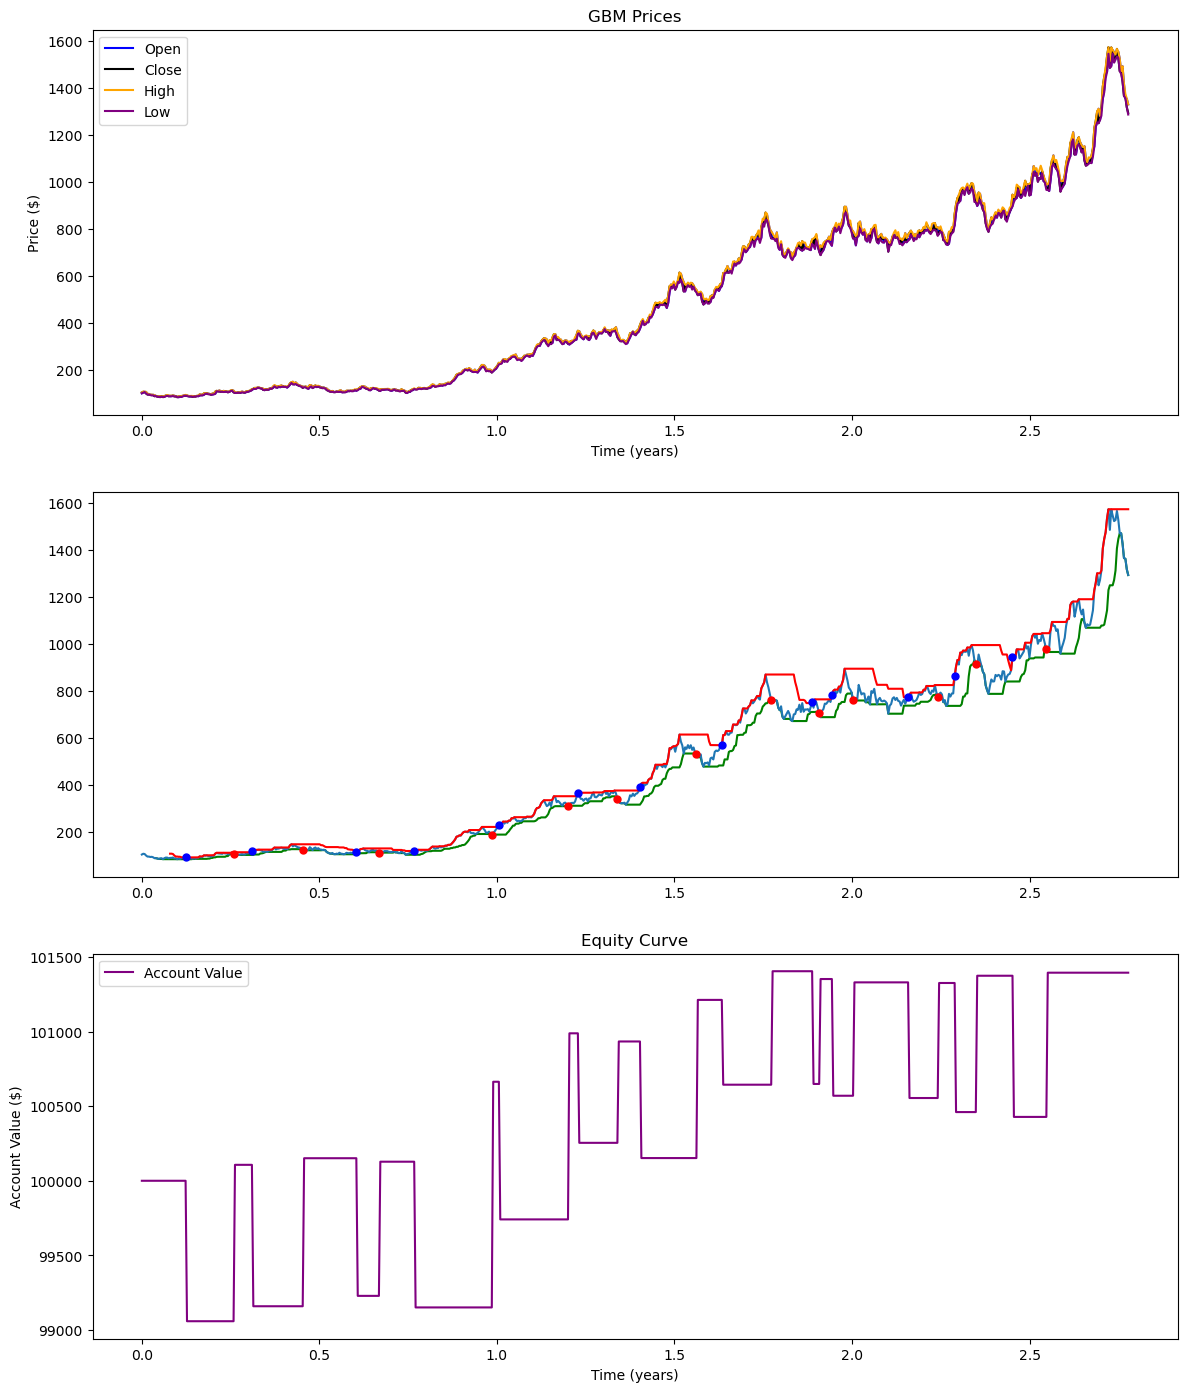

Return after 700 periods: 1.3941 %
Return(%)/MaxDrawdown: 1.4815460882512446


In [3]:
# Set Simple Turtle Strategy (GBM) Parameters

# Path parameters
mu = 0.5                        # GBM Percentage Drift
sigma = 0.5                    # GBM Percentage Volatility 
S0 = 100                        # Initial Stock Price 
n = 700                         # Number of trading periods (days)
prices_per_n = 4                # Number of price points per period (for calculation of Open, High, Low, and Close)
path_params = [mu, sigma, S0, n, prices_per_n]

# Strategy Parameters
initial_account_value = 100000  # Starting account balance
entry_breakout_period = 20      # Lookback period of entry Donchian Channel
exit_breakout_period = 10       # Lookback period of exit Donchian Channel
exposure = 0.01                 # Risk Exposure: percent of account equity leveraged for a unit
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

# Instantiate and Run the Simulation
turtle1 = sim_turtle1()
turtle1.sim_stochastic(path_params)
turtle1.sim_strategy(strategy_params)

print("Return after", n, "periods:", turtle1.final_return, "%")
print("Return(%)/MaxDrawdown:", turtle1.return_maxdraw)

## III. Monte Carlo Simulations of Returns Given GBM Parameters

### III. i. Monte Carlo 1: Return Distribution with Random GBM Parameters

In [4]:
# Monte Carlo 1 (Random Parameters)

N = 1000      #Number of simulated paths
S0 = 100                     
n = 700               
prices_per_n = 4              
initial_account_value = 100000 
entry_breakout_period = 50      
exit_breakout_period = 20     
exposure = 0.01               
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

returns = np.array([])
max_drawdowns = []
param_bin = []
counter = 0

for i in range(N):
    mu = np.random.rand()*2-1
    sigma = np.random.rand()*2
    path_params = [mu, sigma, S0, n, prices_per_n]

    turtle1 = sim_turtle1()
    turtle1.sim_stochastic(path_params)
    turtle1.sim_strategy(strategy_params, plot=False)

    returns = np.append(returns, turtle1.final_return)
    max_drawdowns.append(turtle1.return_maxdraw)
    param_bin.append((mu, sigma))

    counter += 1
    print('\rIteration number: {}'.format(counter), end='')

Iteration number: 21

C:\Users\icon8\AppData\Local\Temp\ipykernel_20460\866011149.py:160: RuntimeWarning: invalid value encountered in double_scalars
  self.return_maxdraw = (self.equity_curve[-1]/initial_account_value-1) / (1-np.min(self.equity_curve)/initial_account_value)


Iteration number: 1000

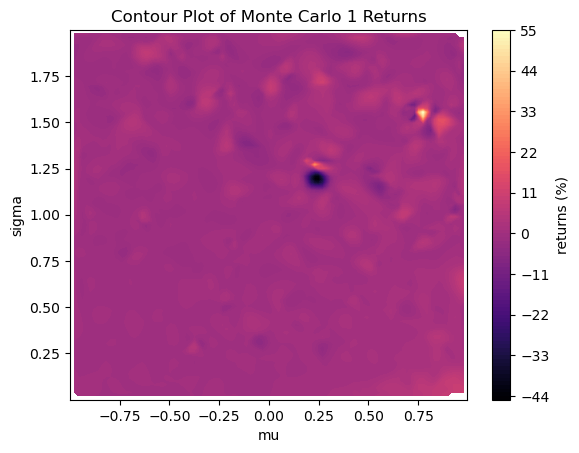

In [5]:
# Visualize Monte Carlo 1

mu = [pair[0] for pair in param_bin]
sigma = [pair[1] for pair in param_bin]
mu_grid, sigma_grid = np.meshgrid(np.linspace(min(mu), max(mu), 100),
                                  np.linspace(min(sigma), max(sigma), 100))

# Interpolate the returns values to fit the grid
returns_grid = griddata((mu, sigma), returns, (mu_grid, sigma_grid), method='cubic')

plt.contourf(mu_grid, sigma_grid, returns_grid, levels=100, cmap='magma')
plt.colorbar(label='returns (%)')
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Contour Plot of Monte Carlo 1 Returns')
plt.show()

- Average returns increase as mu increases. 
- As sigma increases we see greater variability in returns (sunspots). 

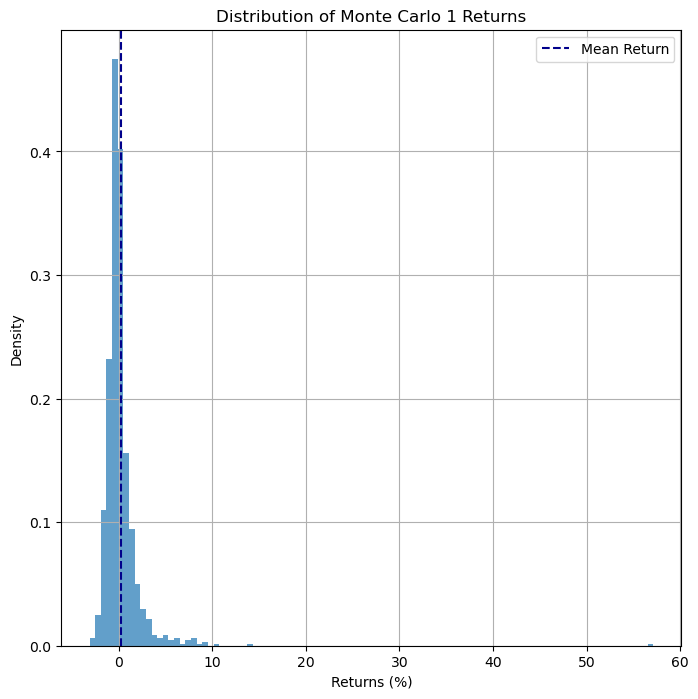

,0
count,1000.000000
mean,0.201824
std,2.405156
min,-3.114100
25%,-0.637725
50%,-0.119350
75%,0.492300
max,57.129500
Kurtosis,316.410699
Skew,14.142984


In [6]:
# Remove extreme outliers
lower, upper = np.percentile(returns, [1,99])
filtered_returns = returns[(returns > lower) & (returns < upper)]

plt.figure(figsize=(8,8))
plt.hist(returns, alpha=0.7, bins=100, density=True)
plt.axvline(np.mean(returns), color="darkblue", linestyle="dashed", label="Mean Return")
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.title("Distribution of Monte Carlo 1 Returns")
plt.legend()
plt.grid(True)
plt.show()

#Return summary statistics
df = pd.DataFrame(returns)
desc_stats = df.describe()
kurtosis = df.kurtosis()
skew = df.skew()
desc_stats.loc['Kurtosis'] = kurtosis
desc_stats.loc['Skew'] = skew
desc_stats

- Distribution of returns with uniformly random parameters resembles Laplace distribution with positive skew.
- Closely centered at zero, with heavy right tail resulting in positive mean despite a negative median.

### III. ii. Monte Carlo 2: Return Distribution with Fixed GBM Parameters

In [7]:
# Monte Carlo 2 (fixed parameters)

N = 100      #Number of simulated paths
S0 = 100                     
n = 700               
prices_per_n = 4              
initial_account_value = 100000 
entry_breakout_period = 20      
exit_breakout_period = 10     
exposure = 0.01               
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

mu_levels = np.linspace(0,1,10)
sigma_levels = np.linspace(0,1,10)
    
turtle1 = sim_turtle1()
returns = np.zeros((len(mu_levels), len(sigma_levels)))
#romad = np.zeros((len(mu_levels), len(sigma_levels)))   # := Return Over Max Drawdown
returns_bin = np.zeros((N, len(mu_levels), len(sigma_levels)))
#romad_bin = np.zeros((N, len(mu_levels), len(sigma_levels)))
counter = 0

for i in range(N):
    for mu_idx, mu in enumerate(mu_levels):
        for sigma_idx, sigma in enumerate(sigma_levels):
            path_params = [mu, sigma, S0, n, prices_per_n]
            turtle1.sim_stochastic(path_params)
            turtle1.sim_strategy(strategy_params, plot=False)
            returns[mu_idx, sigma_idx] = turtle1.final_return 
            #romad[mu_idx, sigma_idx] = turtle1.return_maxdraw
    returns_bin[i] = returns
    #romad_bin[i] = romad
    counter += 1
    print('\rIteration number: {}'.format(counter), end='')

C:\Users\icon8\AppData\Local\Temp\ipykernel_20460\866011149.py:160: RuntimeWarning: invalid value encountered in double_scalars
  self.return_maxdraw = (self.equity_curve[-1]/initial_account_value-1) / (1-np.min(self.equity_curve)/initial_account_value)


Iteration number: 100

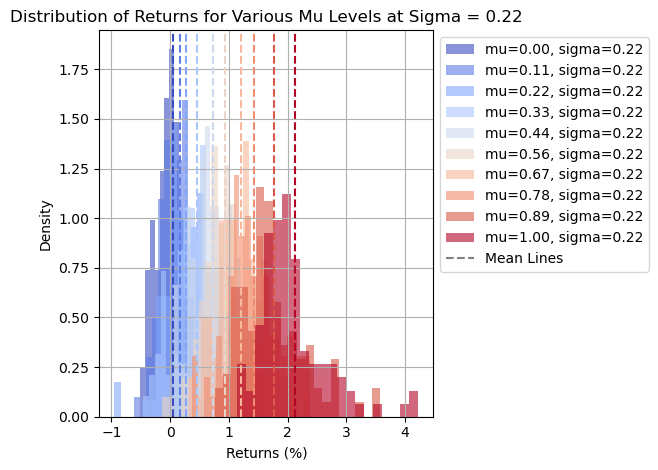

In [8]:
# Visualizing Monte Carlo 2: Density Plots of Returns for Various Mus and Fixed Sigma

fixed_sigma = 0.2
closest_sigma_idx = np.argmin(np.abs(np.array(sigma_levels) - fixed_sigma))
closest_sigma_value = sigma_levels[closest_sigma_idx]

# Initialize histogram legend bins
hist_patches_for_legend = []
hist_labels_for_legend = []

colormap = plt.cm.get_cmap('coolwarm')

for i in range(len(mu_levels)):
    # Extract relevant values of the return matrices
    values_to_plot = returns_bin[:, i, closest_sigma_idx]
    
    # Filter out extreme values
    lower, upper = np.percentile(values_to_plot, [1, 99])
    filtered_values = values_to_plot[(values_to_plot > lower) & (values_to_plot < upper)]
    
    # Density Plots and Mean Lines
    color = colormap(i / (len(mu_levels) - 1))
    hist_patch = plt.hist(filtered_values, bins=20, alpha=0.6, density=True, color=color)[2][0]
    plt.axvline(np.mean(values_to_plot), color=color, linestyle="dashed")
    hist_patches_for_legend.append(hist_patch)
    hist_labels_for_legend.append(f"mu={mu_levels[i]:.2f}, sigma={closest_sigma_value:.2f}")

plt.plot([], color="grey", linestyle="dashed", label="Mean Lines")
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.title(f"Distribution of Returns for Various Mu Levels at Sigma = {closest_sigma_value:.2f}")
plt.grid(True)
plt.legend(hist_patches_for_legend + [plt.Line2D([0], [0], color="grey", linestyle="dashed")], hist_labels_for_legend + ["Mean Lines"], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- As mu increases with fixed sigma, the distribution shifts to the right and the heavy right tail partly redistributes to the right shoulder.
- Represents an improvement to the risk/reward profile. 

C:\Users\icon8\anaconda3\envs\pfe\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


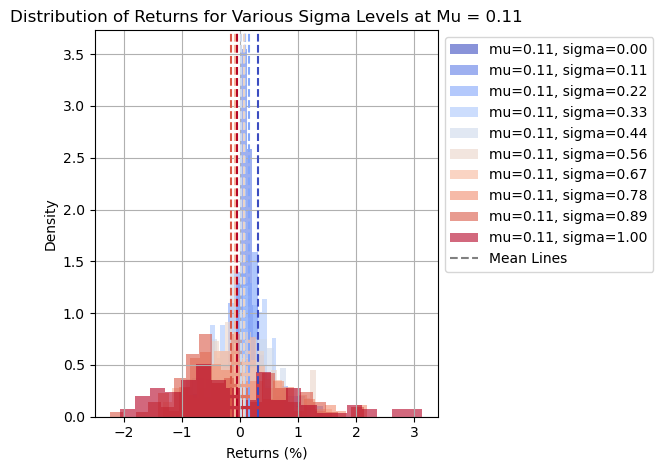

In [9]:
# Visualizing Monte Carlo 2: Density Plots of Returns for Various Sigma and Fixed Mu

fixed_mu = 0.1
closest_mu_idx = np.argmin(np.abs(np.array(mu_levels) - fixed_mu))
closest_mu_value = mu_levels[closest_mu_idx]

# Initialize histogram legend bins
hist_patches_for_legend = []
hist_labels_for_legend = []

colormap = plt.cm.get_cmap('coolwarm')

for i in range(len(sigma_levels)):
    # Extract relevant values of the return matrices
    values_to_plot = returns_bin[:, closest_mu_idx, i]

    # Filter out extreme values
    lower, upper = np.percentile(values_to_plot, [1, 99])
    filtered_values = values_to_plot[(values_to_plot > lower) & (values_to_plot < upper)]

    # Density Plots and Mean Lines
    color = colormap(i / (len(sigma_levels) - 1))
    hist_patch = plt.hist(filtered_values, bins=20, alpha=0.6, density=True, color=color)[2][0]
    plt.axvline(np.mean(values_to_plot), color=color, linestyle="dashed")
    hist_patches_for_legend.append(hist_patch)
    hist_labels_for_legend.append(f"mu={closest_mu_value:.2f}, sigma={sigma_levels[i]:.2f}")

plt.plot([], color="grey", linestyle="dashed", label="Mean Lines")
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.title(f"Distribution of Returns for Various Sigma Levels at Mu = {closest_mu_value:.2f}")
plt.grid(True)
plt.legend(hist_patches_for_legend + [plt.Line2D([0], [0], color="grey", linestyle="dashed")], hist_labels_for_legend + ["Mean Lines"], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- As sigma increases for a given mu, the return distribution flattens and shifts to the left.
- Represents a deterioration of the risk/reward profile. 

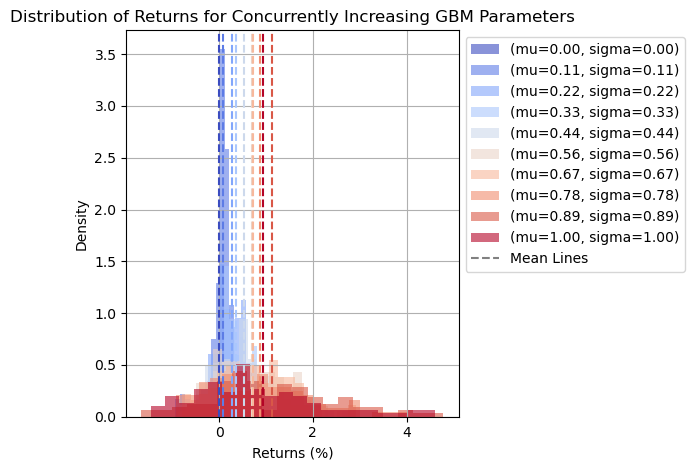

In [10]:
# Visualizing Monte Carlo 2: Density Plots of Returns as Mu and Sigma increase concurrently

# Locate the values where Mu and Sigma are the same value
identity_matrix = np.eye(len(mu_levels))
diagonal_values = returns_bin * identity_matrix

# Initialize legend label storage bins
hist_patches_for_legend = []
hist_labels_for_legend = []

colormap = plt.cm.get_cmap('coolwarm')

for i in range(len(mu_levels)):
    # Extract the i-th diagonal element from each return matrix
    values_to_plot = diagonal_values[:, i, i]
    
    # Filter out extreme values
    lower, upper = np.percentile(values_to_plot, [1, 99])
    filtered_values = values_to_plot[(values_to_plot > lower) & (values_to_plot < upper)]

    # Density Plots and Mean Line
    color = colormap(i / (len(mu_levels) - 1))
    hist_patch = plt.hist(filtered_values, bins=20, alpha=0.6, density=True, color=color)[2][0]
    plt.axvline(np.mean(values_to_plot), color=color, linestyle="dashed")
    hist_patches_for_legend.append(hist_patch)
    hist_labels_for_legend.append(f"(mu={mu_levels[i]:.2f}, sigma={sigma_levels[i]:.2f})")

# Plot a dummy grey line to represent all the mean lines in the legend
plt.plot([], color="grey", linestyle="dashed", label="Mean Lines")

plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.title(f"Distribution of Returns for Concurrently Increasing GBM Parameters")
plt.grid(True)

# Combine the histogram patches and the dummy mean line legend entry
plt.legend(hist_patches_for_legend + [plt.Line2D([0], [0], color="grey", linestyle="dashed")], hist_labels_for_legend + ["Mean Lines"], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- As both mu and sigma increases linearly, the distribution flattens and shifts to the right.
- We see a classical trade-off between risk and reward: high mu and sigma leads to greater variability of portfolio returns, but greater returns in the long-run.

### III. iii. Monte Carlo 3: Regression Analysis of GBM Returns Conditional on GBM Parameters

#### Regression 1: OLS

In [11]:
# OLS Regression of Returns on Various Parameter Values

N = 2000      #Number of simulated paths
S0 = 100                     
n = 700               
prices_per_n = 4              
initial_account_value = 100000 
entry_breakout_period = 20      
exit_breakout_period = 10     
exposure = 0.01               
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

# Initialize Turtle simulation model, dataframe, and counter
turtle1 = sim_turtle1()
df = pd.DataFrame(columns=["mu", "sigma", "returns", "RoMaD"])  # RoMaD := Return over max drawdown
counter = 0

for i in range(N):
    mu = np.random.rand()
    sigma = np.random.rand()
    path_params = [mu, sigma, S0, n, prices_per_n]

    turtle1 = sim_turtle1()
    turtle1.sim_stochastic(path_params)
    turtle1.sim_strategy(strategy_params, plot=False)

    # Append observations to the dataframe
    obs = pd.DataFrame({"mu": [mu], "sigma": [sigma], "returns": [turtle1.final_return], "RoMaD": [turtle1.return_maxdraw]})
    df = pd.concat([df, obs], ignore_index=True)

    counter += 1
    print('\rIteration number: {}'.format(counter), end='')


Iteration number: 2000

In [12]:
# Generate Additional Variables
df['mu_sq'] = df['mu'] **2
df['sigma_sq'] = df['sigma'] **2
df['mu_x_sigma'] = df['mu'] * df['sigma'] 

# OLS with Heteroskedasticity-Robust Standard Errors
X = df[["mu", 'mu_sq', "sigma", 'sigma_sq', "mu_x_sigma"]] 
y = df["returns"] 
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
robust_results = results.get_robustcov_results()
print(robust_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     144.0
Date:                Mon, 31 Jul 2023   Prob (F-statistic):          1.04e-130
Time:                        19:42:37   Log-Likelihood:                -3177.1
No. Observations:                2000   AIC:                             6366.
Df Residuals:                    1994   BIC:                             6400.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3749      0.075      4.989      0.0

- All else equal, mu increases average returns by ~4% percentage points. Sigma decreases average returns by ~4% percentage points.
- The positive effect of mu is increasing in mu: at large mu, additional increases in mu result in larger increases of average returns.
- The negative effect of sigma is decreasing in sigma: at large sigma, additional increases in sigma result in smaller decreases of average returns.
- Large mu and large sigma interact to decrease average returns, implying that the risk-reward trade-off between (low mu, low sigma) and (high mu, high sigma) is biased against the latter.

#### Regression 2: LAD

In [13]:
# LAD with additional variables
X = df[["mu", 'mu_sq', "sigma", 'sigma_sq', "mu_x_sigma"]]
y = df["returns"]
X = sm.add_constant(X)

# Define a formula using the column names of the DataFrame
formula = 'returns ~ mu + mu_sq + sigma + sigma_sq + mu_x_sigma'

# Create a QuantReg object using the formula and data
model = smf.quantreg(formula, data=df)

# Fit the model using the LAD method (quantile=0.5)
results = model.fit(q=0.5)

print(results.summary())


                         QuantReg Regression Results                          
Dep. Variable:                returns   Pseudo R-squared:               0.2419
Model:                       QuantReg   Bandwidth:                      0.2708
Method:                 Least Squares   Sparsity:                        1.580
Date:                Mon, 31 Jul 2023   No. Observations:                 2000
Time:                        19:42:37   Df Residuals:                     1994
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1065      0.090      1.186      0.236      -0.070       0.283
mu             2.7571      0.267     10.342      0.000       2.234       3.280
mu_sq          0.5425      0.236      2.302      0.021       0.080       1.005
sigma         -2.0200      0.267     -7.557      0.0

- Least Absolute Deviations (LAD) is more robust to outliers, which are prevalent in the fat tail of the return distribution.
- LAD echos the relationships identified by OLS, albeit with smaller magnitudes.

## III. Monte Carlo Simulations: Path Analysis

### III. i. Monte Carlo 4: Random GBM Parameters

In [14]:
# Monte Carlo 4: Visualize Performance of Paths with Random GBM Parameters

# Initialize path and parameter storage arrays
all_paths = []
p1_paths = []
p2_paths = []
p3_paths = []
p1_mu = []
p2_mu = []
p3_mu = []
p1_sigma = []
p2_sigma = []
p3_sigma = []
n1_paths = []
n2_paths = []
n3_paths = []
n1_mu = []
n2_mu = []
n3_mu = []
n1_sigma = []
n2_sigma = []
n3_sigma = []

# Set return thresholds
p1 = 0.5
p2 = 1
p3 = 2
n1 = -0.5
n2 = -1
n3 = -2

# Set parameters
P = 100      #Number of sampled paths
S0 = 100                     
n = 700               
prices_per_n = 4              
initial_account_value = 100000 
entry_breakout_period = 20      
exit_breakout_period = 10     
exposure = 0.01               
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

# Initialize the Turtle Simulation Modelling Object and Counter
turtle1 = sim_turtle1()
counter = 0 

for i in range(P):
    # Set variables    
    mu = np.random.rand()    
    sigma = np.random.rand()+0.05
    path_params = [mu, sigma, S0, n, prices_per_n]

    # Simulate System 1
    turtle1.sim_stochastic(path_params)
    turtle1.sim_strategy(strategy_params, plot=False)
    returns = turtle1.final_return

    # Classify paths by performance relative to threshold
    all_paths.append(turtle1.close)    
    if returns >= p1:
        p1_paths.append(turtle1.close)
        p1_mu.append(mu)
        p1_sigma.append(sigma)
    if returns >= p2:
        p2_paths.append(turtle1.close)
        p2_mu.append(mu)
        p2_sigma.append(sigma)
    if returns >= p3:
        p3_paths.append(turtle1.close)
        p3_mu.append(mu)
        p3_sigma.append(sigma)
    if returns <= n1:
        n1_paths.append(turtle1.close)
        n1_mu.append(mu)
        n1_sigma.append(sigma)
    if returns <= n2:
        n2_paths.append(turtle1.close)
        n2_mu.append(mu)
        n2_sigma.append(sigma)
    if returns <= n3:
        n3_paths.append(turtle1.close)
        n3_mu.append(mu)
        n3_sigma.append(sigma)
        
    counter += 1
    print('\rIteration number: {}'.format(counter), end='')

Iteration number: 100

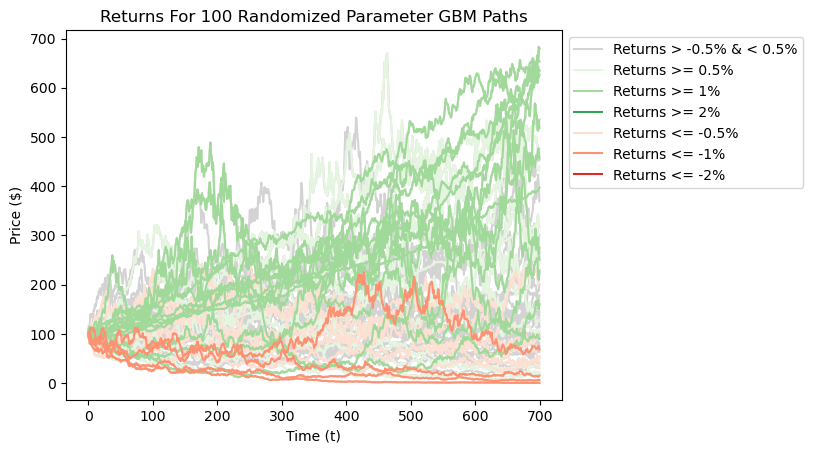

------------- POSITIVE RETURN PATHS -------------
Number of Paths with >= 0.5% Returns (%): 60
Number of Paths with >= 1% Returns (%): 39
Number of Paths with >= 2% Returns (%): 10

------------- NEGATIVE RETURN PATHS -------------
Number of Paths with <= -0.5% Returns (%): 11
Number of Paths with <= -1% Returns (%): 4
Number of Paths with <= -2% Returns (%): 0


In [15]:
#Plot the results
fig, ax = plt.subplots()
global_max=700
for i in all_paths:
    if max(i) <= global_max:
        ax.plot(i, c="lightgrey", zorder=1)
for p1_i in p1_paths:
    if max(p1_i) <= global_max:
        ax.plot(p1_i, c="#e5f5e0", zorder=2)
for p2_i in p2_paths:
    if max(p2_i) <= global_max:
        ax.plot(p2_i, c="#a1d99b", zorder=4)
for p3_i in p3_paths:
    if max(p3_i) <= global_max:
        ax.plot(p3_i, c="#31a354", zorder=6)
for n1_i in n1_paths:
    if max(n1_i) <= global_max:
        ax.plot(n1_i, c="#fee0d2", zorder=3)
for n2_i in n2_paths:
    if max(n2_i) <= global_max:
        ax.plot(n2_i, c="#fc9272", zorder=5)
for n3_i in n3_paths:
    if max(n3_i) <= global_max:
        ax.plot(n3_i, c="#de2d26", zorder=7)

ax.plot([], [], label=f"Returns > {n1}% & < {p1}%", c="lightgrey")
ax.plot([], [], label=f"Returns >= {p1}%", c="#e5f5e0")
ax.plot([], [], label=f"Returns >= {p2}%", c="#a1d99b")
ax.plot([], [], label=f"Returns >= {p3}%", c="#31a354") 
ax.plot([], [], label=f"Returns <= {n1}%", c="#fee0d2")
ax.plot([], [], label=f"Returns <= {n2}%", c="#fc9272")
ax.plot([], [], label=f"Returns <= {n3}%", c="#de2d26") 

plt.title(f"Returns For {P} Randomized Parameter GBM Paths")
plt.xlabel("Time (t)")
plt.ylabel("Price ($)")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

print("------------- POSITIVE RETURN PATHS -------------")        
print(f"Number of Paths with >= {p1}% Returns (%):", len(p1_paths))
print(f"Number of Paths with >= {p2}% Returns (%):", len(p2_paths))
print(f"Number of Paths with >= {p3}% Returns (%):", len(p3_paths))
print()
print("------------- NEGATIVE RETURN PATHS -------------")        
print(f"Number of Paths with <= {n1}% Returns (%):", len(n1_paths))
print(f"Number of Paths with <= {n2}% Returns (%):", len(n2_paths))
print(f"Number of Paths with <= {n3}% Returns (%):", len(n3_paths))

- Paths that lead to poor performance tend to display weak drift. 
- Paths that lead to high performance display stable drift or rapid ascents (arising from high sigma, moderate/low drift).

### III. ii. Monte Carlo 5: Random GBM Parameters

In [16]:
# Measure sigma and mu from S&P500 Close Data

symbol = '^GSPC'
stock_data = yf.Ticker(symbol)

df = stock_data.history(period="5y")
log_returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
mu = log_returns.mean()
sigma = log_returns.std()
annualized_mu = mu * 252
annualized_sigma = sigma * np.sqrt(252)

print("Estimated daily mu:", mu)
print("Estimated daily sigma:", sigma)
print("Estimated annualized mu:", annualized_mu)
print("Estimated annualized sigma:", annualized_sigma)

Estimated daily mu: 0.00038682863888860904
Estimated daily sigma: 0.01374990881279202
Estimated annualized mu: 0.09748081699992948
Estimated annualized sigma: 0.21827303561077832


In [17]:
# Monte Carlo 5: Visualize Performance of Paths with Fixed GBM Parameters

# Initialize path and parameter storage arrays
all_paths = []
p1_paths = []
p2_paths = []
p3_paths = []
p1_mu = []
p2_mu = []
p3_mu = []
p1_sigma = []
p2_sigma = []
p3_sigma = []
n1_paths = []
n2_paths = []
n3_paths = []
n1_mu = []
n2_mu = []
n3_mu = []
n1_sigma = []
n2_sigma = []
n3_sigma = []

# Set return thresholds
p1 = 0.5
p2 = 1
p3 = 2
n1 = -0.5
n2 = -1
n3 = -2

# Set parameters
P = 100      #Number of sampled paths
S0 = 100                     
n = 700               
prices_per_n = 4              
initial_account_value = 100000 
entry_breakout_period = 20      
exit_breakout_period = 10     
exposure = 0.01               
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

# Initialize the Turtle Simulation Modelling Object and Counter
turtle1 = sim_turtle1()
counter = 0 

for i in range(P):
    # Set variables    
    mu = annualized_mu          #0.09856230862961128
    sigma = annualized_sigma     #0.2182818945192235
    path_params = [mu, sigma, S0, n, prices_per_n]

    # Simulate System 1
    turtle1.sim_stochastic(path_params)
    turtle1.sim_strategy(strategy_params, plot=False)
    returns = turtle1.final_return

    # Classify paths by performance relative to threshold
    all_paths.append(turtle1.close)    
    if returns >= p1:
        p1_paths.append(turtle1.close)
        p1_mu.append(mu)
        p1_sigma.append(sigma)
    if returns >= p2:
        p2_paths.append(turtle1.close)
        p2_mu.append(mu)
        p2_sigma.append(sigma)
    if returns >= p3:
        p3_paths.append(turtle1.close)
        p3_mu.append(mu)
        p3_sigma.append(sigma)
    if returns <= n1:
        n1_paths.append(turtle1.close)
        n1_mu.append(mu)
        n1_sigma.append(sigma)
    if returns <= n2:
        n2_paths.append(turtle1.close)
        n2_mu.append(mu)
        n2_sigma.append(sigma)
    if returns <= n3:
        n3_paths.append(turtle1.close)
        n3_mu.append(mu)
        n3_sigma.append(sigma)
        
    counter += 1
    print('\rIteration number: {}'.format(counter), end='')

Iteration number: 100

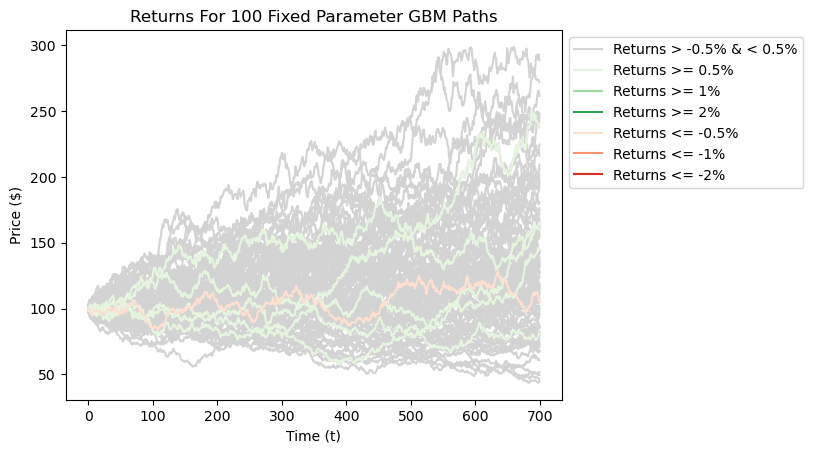

------------- POSITIVE RETURN PATHS -------------
Number of Paths with >= 0.5% Returns (%): 5
Number of Paths with >= 1% Returns (%): 0
Number of Paths with >= 2% Returns (%): 0

------------- NEGATIVE RETURN PATHS -------------
Number of Paths with <= -0.5% Returns (%): 1
Number of Paths with <= -1% Returns (%): 0
Number of Paths with <= -2% Returns (%): 0


In [18]:
#Plot the results
fig, ax = plt.subplots()
global_max=700
for i in all_paths:
    if max(i) <= global_max:
        ax.plot(i, c="lightgrey", zorder=1)
for p1_i in p1_paths:
    if max(p1_i) <= global_max:
        ax.plot(p1_i, c="#e5f5e0", zorder=2)
for p2_i in p2_paths:
    if max(p2_i) <= global_max:
        ax.plot(p2_i, c="#a1d99b", zorder=4)
for p3_i in p3_paths:
    if max(p3_i) <= global_max:
        ax.plot(p3_i, c="#31a354", zorder=6)
for n1_i in n1_paths:
    if max(n1_i) <= global_max:
        ax.plot(n1_i, c="#fee0d2", zorder=3)
for n2_i in n2_paths:
    if max(n2_i) <= global_max:
        ax.plot(n2_i, c="#fc9272", zorder=5)
for n3_i in n3_paths:
    if max(n3_i) <= global_max:
        ax.plot(n3_i, c="#de2d26", zorder=7)

ax.plot([], [], label=f"Returns > {n1}% & < {p1}%", c="lightgrey")
ax.plot([], [], label=f"Returns >= {p1}%", c="#e5f5e0")
ax.plot([], [], label=f"Returns >= {p2}%", c="#a1d99b")
ax.plot([], [], label=f"Returns >= {p3}%", c="#31a354") 
ax.plot([], [], label=f"Returns <= {n1}%", c="#fee0d2")
ax.plot([], [], label=f"Returns <= {n2}%", c="#fc9272")
ax.plot([], [], label=f"Returns <= {n3}%", c="#de2d26") 

plt.title(f"Returns For {P} Fixed Parameter GBM Paths")
plt.xlabel("Time (t)")
plt.ylabel("Price ($)")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

print("------------- POSITIVE RETURN PATHS -------------")        
print(f"Number of Paths with >= {p1}% Returns (%):", len(p1_paths))
print(f"Number of Paths with >= {p2}% Returns (%):", len(p2_paths))
print(f"Number of Paths with >= {p3}% Returns (%):", len(p3_paths))
print()
print("------------- NEGATIVE RETURN PATHS -------------")        
print(f"Number of Paths with <= {n1}% Returns (%):", len(n1_paths))
print(f"Number of Paths with <= {n2}% Returns (%):", len(n2_paths))
print(f"Number of Paths with <= {n3}% Returns (%):", len(n3_paths))

- Weak drift components are more dangerous than strong negative ones, because in the former case, the Turtle Strategy continues to trades in periods of whipsaw (rangebound prices). In the latter case, the Turtle Strategy sees fewer entry signals and simply ceases to trade. 

### III. iii. Path Segment Analysis 

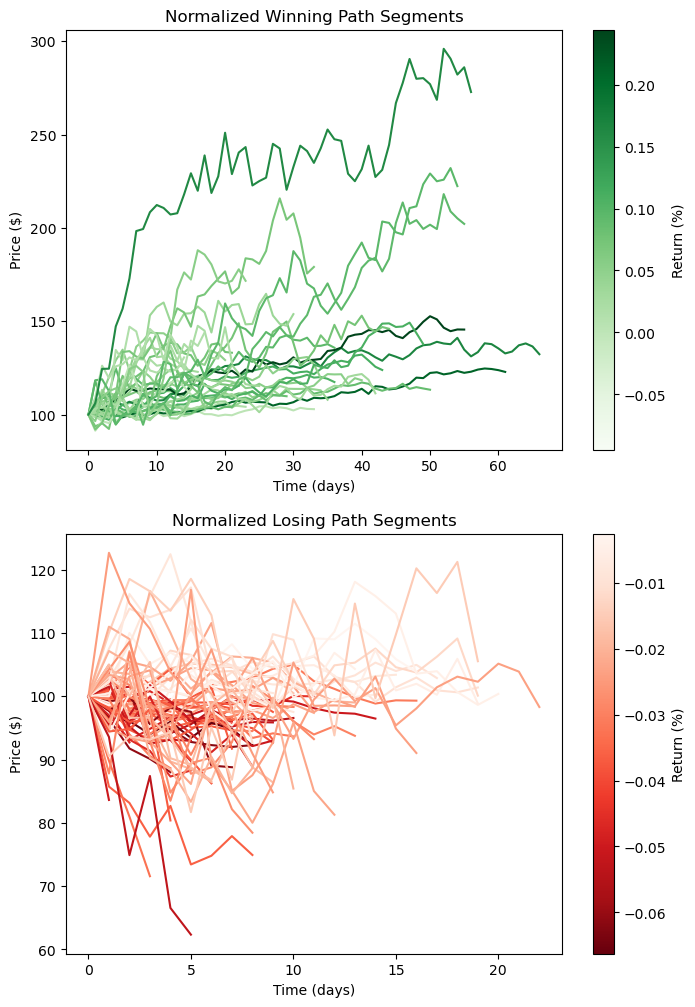

In [19]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
mu = annualized_mu          #0.09856230862961128
sigma = annualized_sigma     #0.2182818945192235
prices_per_n = 4   
S0 = 100
n = 5000     
path_params = [mu, sigma, S0, n, prices_per_n]

initial_account_value = 100000 
entry_breakout_period = 20      
exit_breakout_period = 10     
exposure = 0.01               
strategy_params = [initial_account_value, entry_breakout_period, exit_breakout_period, exposure]

turtle1 = sim_turtle1()
turtle1.sim_stochastic(path_params)
turtle1.sim_strategy(strategy_params, plot=False)

# Create a list of returns and segments
segment_returns = [turtle1.winning_segment_returns, turtle1.losing_segment_returns]
segment_paths = [turtle1.winning_segments, turtle1.losing_segments]

# Create empty lists to hold filtered returns and segments
filtered_returns = []
filtered_segments = []

# Filter outliers
for returns, paths in zip(segment_returns, segment_paths):
    lower, upper = np.percentile(returns, [1, 99])
    filtered_idx = (returns > lower) & (returns < upper)
    filtered_returns.append(np.array(returns)[filtered_idx])
    filtered_segments.append([path for i, path in enumerate(paths) if filtered_idx[i]])

# Extract filtered winning and losing segments and returns
winning_segment_returns, losing_segment_returns = filtered_returns
winning_segments, losing_segments = filtered_segments


# Create normalization objects for color mapping
shift= -0.4
shift_inv = 0
winning_norm = Normalize(vmin=np.min(winning_segment_returns) + shift * (np.max(winning_segment_returns) - np.min(winning_segment_returns)), vmax=np.max(winning_segment_returns))
losing_norm = Normalize(vmin=np.min(losing_segment_returns) + shift_inv * (np.max(losing_segment_returns) - np.min(losing_segment_returns)), vmax=np.max(losing_segment_returns))

plt.figure(figsize=(8, 12))

ax1 = plt.subplot(2, 1, 1)
for i, segment in enumerate(winning_segments):
    segment = segment - segment[0] + 100
    color = cm.Greens(winning_norm(winning_segment_returns[i]))
    plt.plot(segment, color=color)
plt.title("Normalized Winning Path Segments")
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.colorbar(cm.ScalarMappable(norm=winning_norm, cmap='Greens'), label='Return (%)', ax=ax1)

ax2 = plt.subplot(2, 1, 2)
for j, segment in enumerate(losing_segments):
    segment = segment - segment[0] + 100
    color = cm.Reds_r(losing_norm(losing_segment_returns[j]))
    plt.plot(segment, color=color)
plt.title("Normalized Losing Path Segments")
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.colorbar(cm.ScalarMappable(norm=losing_norm, cmap='Reds_r'), label='Return (%)', ax=ax2)

plt.show()


- Isolates the path segments associated with winning/losing trades, normalized to start at the same price. 
- Winning segments tend to display positive drift, low sigma, echoing previous Monte Carlo Simulations.
- Losing segments display much greater horizontality. Weak trends are more dangerous than strong negative trends. 
- Winning/losing trades occasionally result even when the exit (closing) price is greater/smaller than the entry (closing) price, due to slippage (shares are sold at the day's low, and bought at the day's high, not the close). 
